In [1]:
%load_ext autoreload
%autoreload 2

In [333]:
import descarteslabs as dl
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from sklearn.metrics import precision_recall_curve
from rasterio import warp
from tensorflow import keras

from scripts.dl_utils import download_patch, rect_from_point
from scripts.nn_predict import make_predictions, visualize_predictions

In [305]:
model = keras.models.load_model('../models/model_v1.1.8_5-07-21.h5')
model_baseline = keras.models.load_model('../models/65_mo_tpa_bootstrap_toa-12-20-2020.h5')

In [298]:
data = gpd.read_file('../data/sampling_locations/validation_positives.geojson')

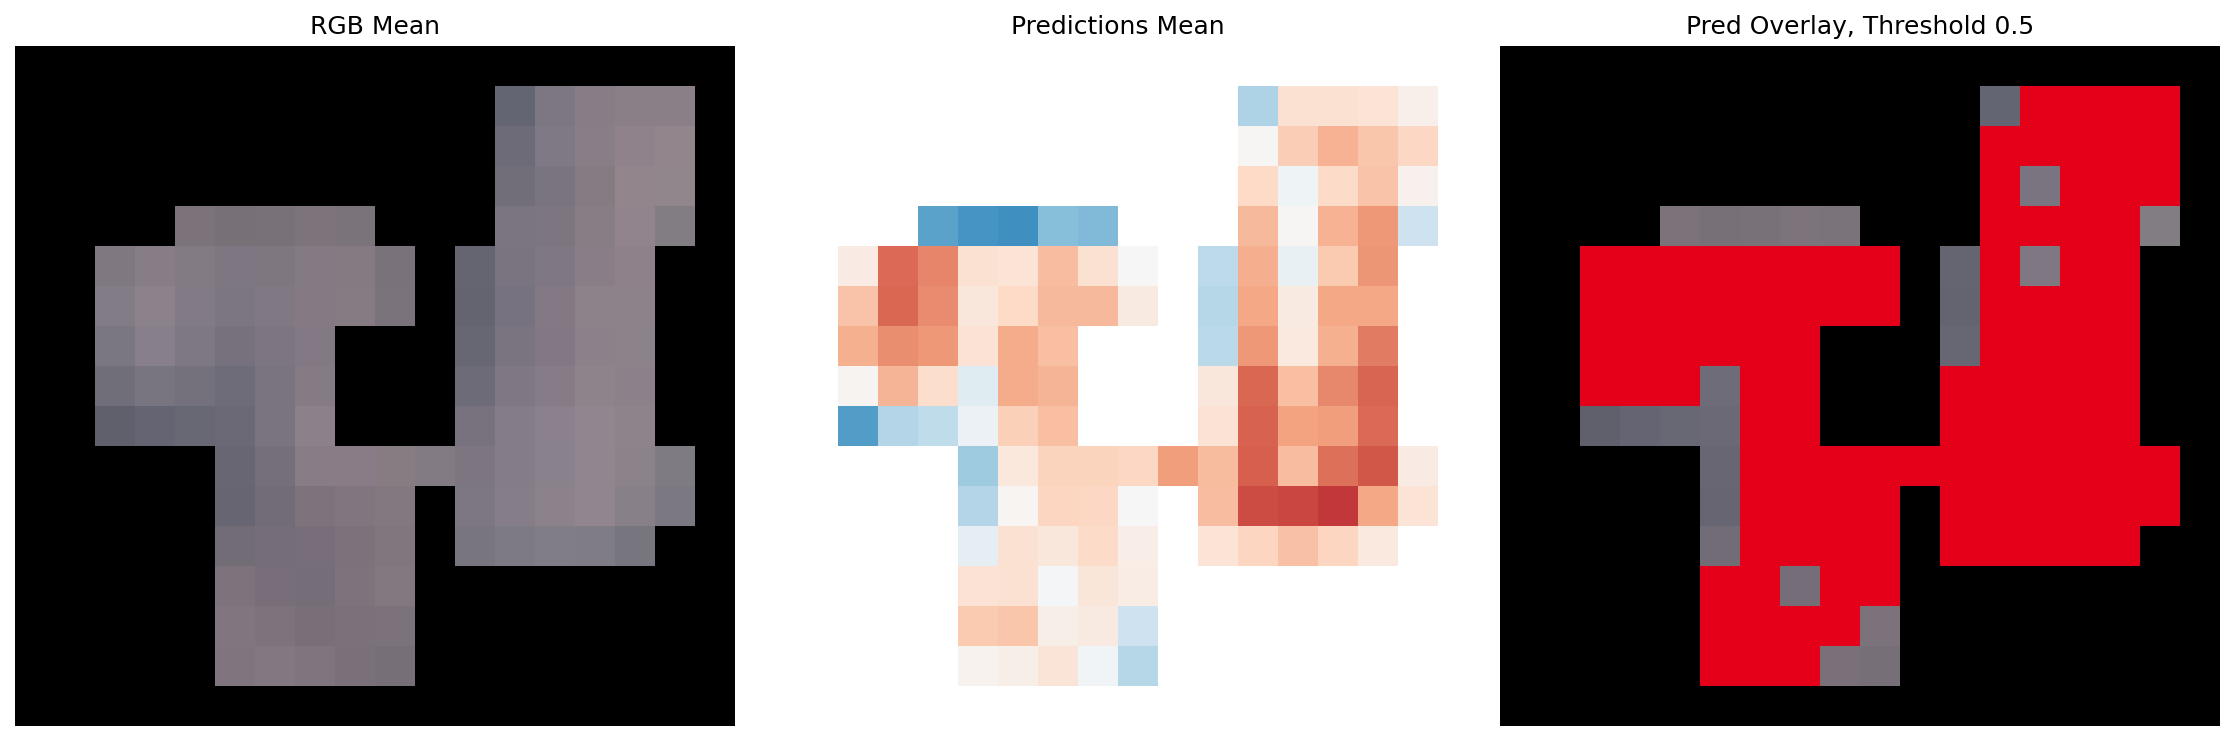

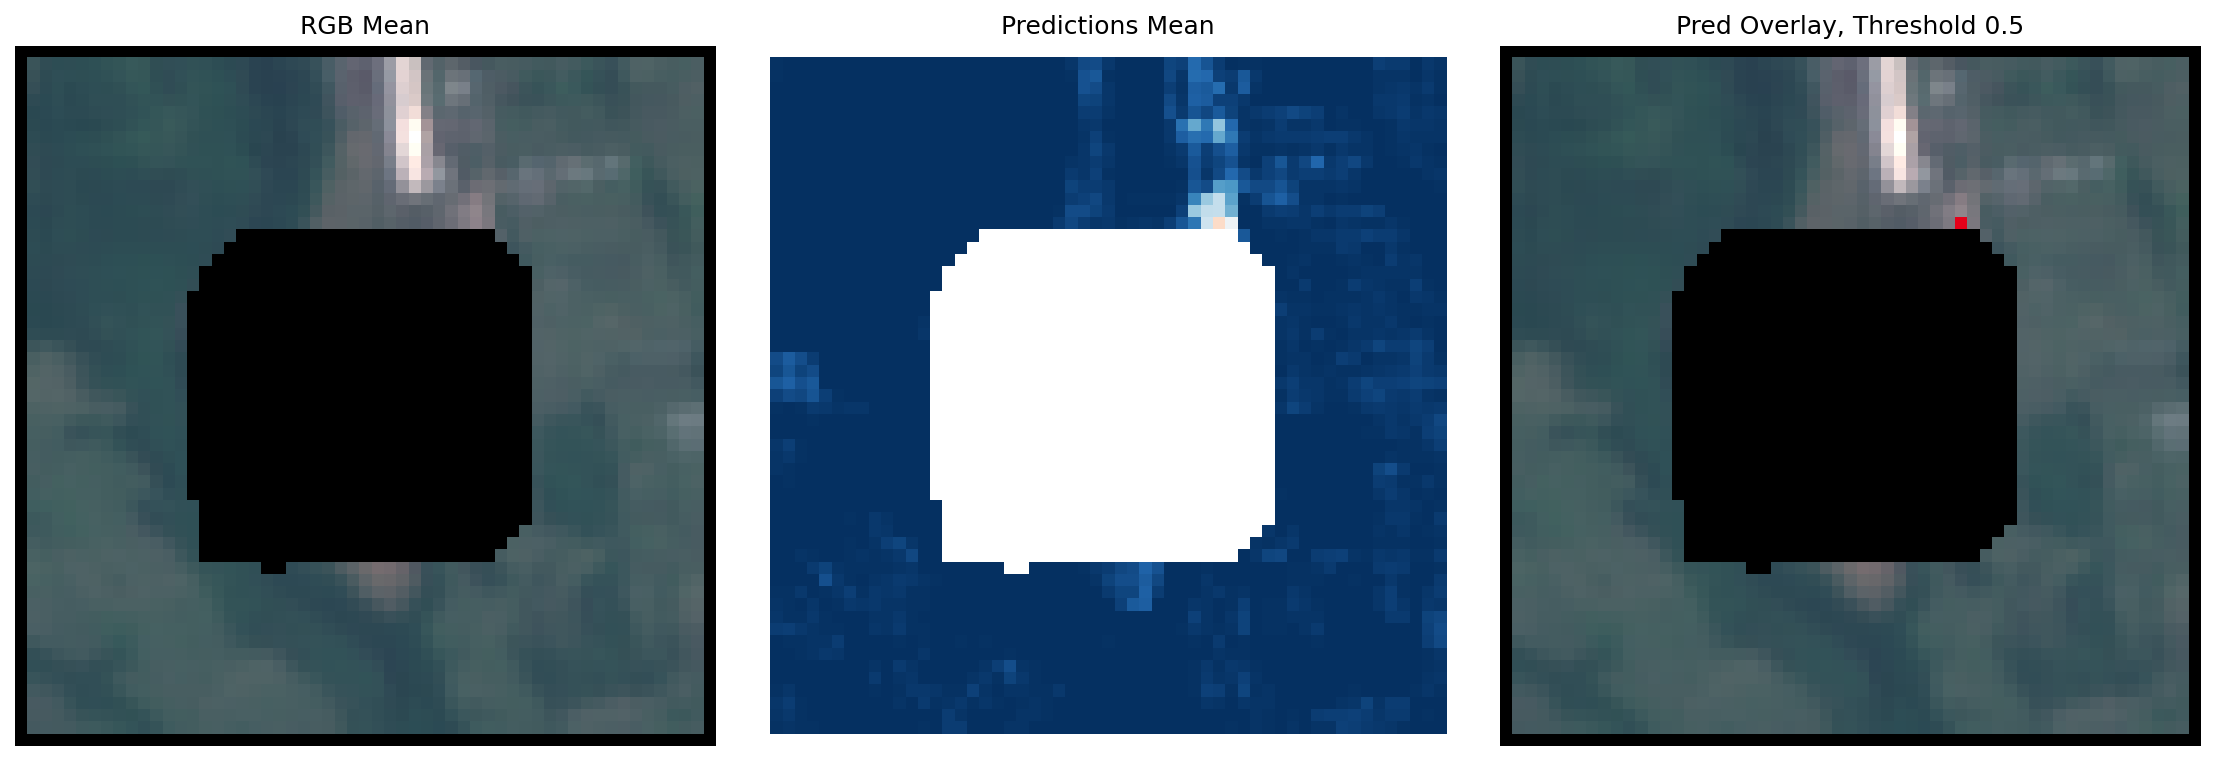

In [265]:
rect_width = 0.005
threshold = 0.5

interior_preds = []
exterior_preds = []
interior_preds_baseline = []
exterior_preds_baseline = []
for index, site in data.iterrows():
    int_poly = site['geometry']
    ext_poly = shape(rect_from_point([int_poly.centroid.x, int_poly.centroid.y], rect_width)) - int_poly.envelope.buffer(0.001)
    start_date = site['start_date']
    end_date = site['end_date']
    
    int_patches = download_patch(int_poly, start_date, end_date)
    int_preds = make_predictions(int_patches, model)
    visualize_predictions(int_patches, int_preds, threshold=threshold)
    for pred in int_preds:
        interior_preds += list(pred[~pred.mask].data)
    int_preds_baseline = make_predictions(int_patches, model_baseline)
    for pred in int_preds_baseline:
        interior_preds_baseline += list(pred[~pred.mask].data)
    
    ext_patches = download_patch(ext_poly, start_date, end_date)
    ext_preds = make_predictions(ext_patches, model)
    for pred in ext_preds:
        exterior_preds += list(pred[~pred.mask].data)
    ext_preds_baseline = make_predictions(ext_patches, model_baseline)
    for pred in ext_preds_baseline:
        exterior_preds_baseline += list(pred[~pred.mask].data)
    visualize_predictions(ext_patches, ext_preds, threshold=threshold)

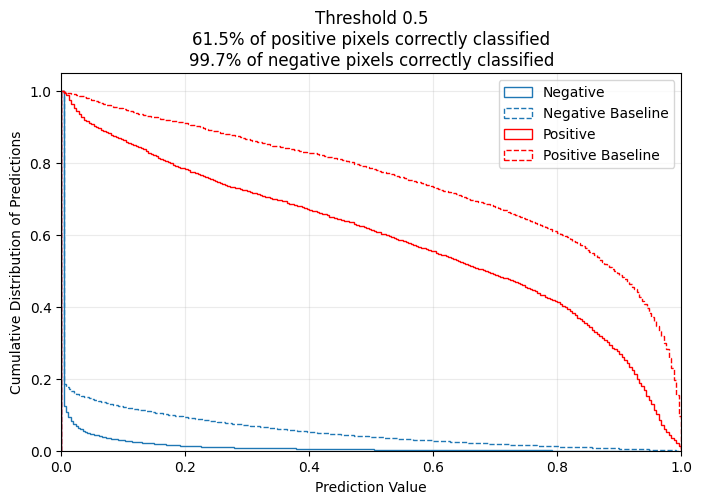

In [339]:
plt.figure(figsize=(8,5), dpi=100)
plt.hist(exterior_preds, bins=250, cumulative=-1, density=True, histtype='step', label='Negative', color='C0')
plt.hist(exterior_preds_baseline, bins=250, cumulative=-1, density=True, histtype='step', label='Negative Baseline', linestyle='dashed', color='C0')
plt.hist(interior_preds, bins=250, cumulative=-1, density=True, histtype='step', color='r', label='Positive')
plt.hist(interior_preds_baseline, bins=250, cumulative=-1, density=True, histtype='step', label='Positive Baseline', linestyle='dashed', color='r')
plt.grid(alpha=0.25)
plt.xlim([0,1])
plt.xlabel('Prediction Value')
plt.ylabel('Cumulative Distribution of Predictions')
plt.legend()
plt.title(f"Threshold {threshold}\n{np.sum(np.array(interior_preds) > threshold) / len(interior_preds):.1%} of positive pixels correctly classified\n{np.sum(np.array(exterior_preds) <= threshold) / len(exterior_preds):.1%} of negative pixels correctly classified")
plt.show()

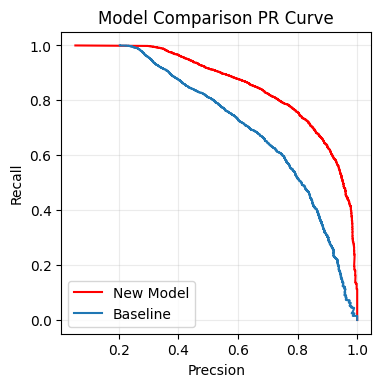

In [340]:
labels = [1] * len(interior_preds) + [0] * len(exterior_preds)
preds = interior_preds + exterior_preds
p, r, thresh = precision_recall_curve(labels, preds)
plt.figure(figsize=(4,4), dpi=100)
plt.plot(p,r, label='New Model', color='r')

preds_b = interior_preds_baseline + exterior_preds_baseline
p_b, r_b, thresh = precision_recall_curve(labels, preds_b)
plt.plot(p_b,r_b, label='Baseline', color='C0')
plt.xlabel('Precsion')
plt.ylabel('Recall')
plt.legend()
plt.grid(alpha=0.25)
plt.title('Model Comparison PR Curve')
plt.show()